# Overview
This notebook is intended to provide some easy methods for computing grid convergence.


The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_n = \{\text{'west', 'east'}\},\quad 
\partial \Omega_d = \{\text{'south', 'north'}\} 
$$

with data: 
$$
f=0, \quad
K=1, \quad 
u_b = 0, \quad
\text{ and }\quad  
p_b = 1 \text{ at top}, \quad
p_b = 0 \text{ at bottom}
$$

In [1]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp
import matplotlib.pyplot as plt

In [2]:
from porepy.geometry.geometry_property_checks import is_ccw_polyline, is_ccw_polygon, point_in_polygon

def make_points_ccw(p, tol=1e-5):
    """
    Return the points sorted in ccw order.
    
    Sort points in 2D, by ccw order. Not tested for non-convex point sets.
    
    Parameters:
        p (np.ndarray, 2 x n): Points to be sorted.
    
    Returns:
        np.ndarray, ccw sorted list of points.
        
    Steps of algorithm:
    Let poly = p.copy()
    
    CASE I: 3 points provided.
    1. Check if points are collinear.
        - If True: Raise ValueError.
    2. Run is_ccw_polyline(poly) 
        - If True: Return poly
        - Otherwise: Return poly.copy()[:, ::-1]
        
    CASE II: 4 points provided.
    1. Name the points A,B,C,D.
    2. Consider two points, e.g. AB.
    3. Check if any of C and D is collinear to AB.
        a. If any:
            - Raise ValueError
    3. Check that C and D is ccw relative to AB
        a. If both cw: 
            - Continue with XY = BA.
        b. If one cw and one ccw:
            - Continue with XY = AC (or AD, it doesn't matter)
        c. If both ccw: 
            - Continue with XY = AB
    4. Name the other two points Z, W.
    5. Run is_ccw_polygon on XYZW and XYWZ.
        a. Return the case which is True.
        
    CASE III: Number of points provided > 4.
    1. Raise NotYetImplementedError.
    
    """
    
    num_p = p.shape[1]
    poly = p.copy()
    
    assert(num_p > 2) # Need to provide at least 3 points.
    
    # CASE I:
    if num_p == 3:
        A,B,C = poly.T
        if np.abs(np.cross(C-A,B-A)) < tol:
            raise ValueError("Points are collinear.")
        
        if is_ccw_polyline(A,B,C,tol=tol):
            return poly
        else:
            return poly.copy()[:, ::-1]
    
    # CASE II:
    elif num_p == 4:
        A,B,C,D = poly.T
        collC = np.abs(np.cross(C-A,B-A)) < tol
        collD = np.abs(np.cross(D-A,B-A)) < tol
        if collC or collD:
            raise ValueError("Some triples of points are collinear.")
        
        orientations = is_ccw_polyline(A,B,np.array((C,D)).T)
        if np.all(np.logical_not(orientations)):  # Both other pts are cw.
            A,B = B,A
        elif np.any(np.logical_not(orientations)): # Exactly one pt is cw.
            B,C=C,B
        
        # Either ABCD or ABDC is either cw or ccw.
        arr1 = np.array((A,B,C,D)).T
        arr2 = np.array((A,B,D,C)).T
        if is_ccw_polygon(arr1):
            return arr1
        elif is_ccw_polygon(arr1[:, ::-1]):
            return arr1[:, ::-1]
        elif is_ccw_polygon(arr2):
            return arr2
        elif is_ccw_polygon(arr2[:, ::-1]):
            return arr2[:, ::-1]
        else:
            raise Error("An unexpected error occured.")
        
    
    elif num_p > 4:
        raise NotImplemented("Not implemented for larger polygons.")
        

def identify_overlap(gc, gf):
    """
    Method to find overlapping cells in two grids over the same domain (2D).
    
    Parameters:
    gc (porepy.Grid): The coarse grid with Nc number of cells
    gf (porepy.Grid): The fine grid with Nf number of cells
    
    Returns:
    Nf x Nc sparse matrix: If entry (i,j)  contains 1, then cell i in the fine grid 
                           is contained in cell j in the coarse grid.
                            
    """
    
    # cell_nodes is a num_nodes x num_cells sparse column oriented matrix. (sps.csc_matrix).
    ccell_nodes = gc.cell_nodes()
    cnnz = ccell_nodes.nnz
    slices = zip(ccell_nodes.indptr[:-1], ccell_nodes.indptr[1:])
    
    # Create sps.csc_matrix mapping coarse cells to fine cell centers.
    indptr = [0]
    indices = []
    
    for st, nd in slices:  # Loop through every cell.
        nodes = ccell_nodes.indices[st:nd]
        node_coords = np.array(gc.nodes[:,nodes][0:2])
        poly = make_points_ccw(node_coords)
        inside = point_in_polygon(poly, gf.cell_centers)#, tol=1e-5, default=True)
        inside_id = np.array([i for i, x in enumerate(inside) if x])  # Location of the (fine) nodes inside the coarse cell.
        
        indptr.extend([indptr[-1]+len(inside_id)])  # Update index pointer
        indices.extend(inside_id)  # Update indices of fine cells for the current coarse cell.
    
    data = np.ones(len(indices))
    
    ccell_fcell = sps.csc_matrix((data, indices, indptr))
    return ccell_fcell
        

In [3]:
def sp_flow(g):
    """ Method to compute single phase flow for a given grid."""
    
    # Boundary conditions
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    labels = np.array(['neu']*b_faces.size)
    labels[g.face_centers[1, b_faces] == 0.] = 'dir'
    labels[g.face_centers[1, b_faces] == 1.] = 'dir'
    
    bc = pp.BoundaryCondition(g, b_faces, labels)
    
    # In-flow on top. outflow on bottom.
    #bottom = b_faces[g.face_centers[1, b_faces] == 0.]
    top = b_faces[g.face_centers[1, b_faces] == 1.]
    bc_val = np.zeros(g.num_faces)
    #bc_val[bottom] = np.zeros(bottom.size)
    bc_val[top] = np.ones(top.size)
    
    # Permeability
    perm = pp.SecondOrderTensor(np.ones(g.num_cells))
    
    # Source
    f = np.zeros(g.num_cells)
    
    # Build problem
    specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(g, {}, "flow", specified_parameters)
    
    # Solve problem
    solver = pp.Tpfa("flow")
    solver.discretize(g, data)
    A, b = solver.assemble_matrix_rhs(g, data)
    p = sps.linalg.spsolve(A, b)
    return p

In [4]:
def grid_convergence(N=[8,16,32,64,128],plotting=False):
    """ Compute grid convergence. Use last N as reference value"""
    norm = np.ones(len(N)-1)
    
    sol = [] # Store all solutions
    g_bucket = []  # Store all grids
    for i in range(len(N)):
        Nx = Ny = N[i]
         # Create grid
        g = pp.CartGrid([Nx,Ny], [1,1])
        g.compute_geometry()
        g_bucket.append(g.copy())
        
        # Compute solution
        sol.append(sp_flow(g))
        
        # Compute L2-norm.
        # Not sure if this is accurate since we are not comparing
        # the same volumes, rather doing norm over all current values
        #norm[i] = pp.error.norm_L2(g, val)
    
    # Now, map all coarse solution to the fine grid.
    mapped_sol = []
    ref_grid_num_cells = len(sol[-1])
    g_ref = g_bucket[-1]
    ref_sol = sol[-1]
    for i in range(len(N)-1): 
        arr = np.zeros(ref_grid_num_cells)
        g = g_bucket[i]
        p = sol[i]
        
        mapping = identify_overlap(gc=g, gf=g_ref)
        slices = zip(mapping.indptr[:-1], mapping.indptr[1:])
        for j, stnd in enumerate(slices):
            st,nd=stnd
            nodes = mapping.indices[st:nd]
            arr[nodes] = p[j]
            
        mapped_sol.append(arr)
        norm[i] = pp.error.norm_L2(g_ref,arr-ref_sol)
        
       
        
        
    #errors = np.abs(norm[:-1] - norm[-1])
    errors=norm
    slope = np.log(errors[-1] / errors[-2]) / np.log(N[-2] / N[-3])
    slope = np.abs(slope)
        
    if plotting:
        plt.loglog(N[:-1], errors)
        plt.title(f"Slope: {slope}")
        plt.show()
    
    return errors, slope
        

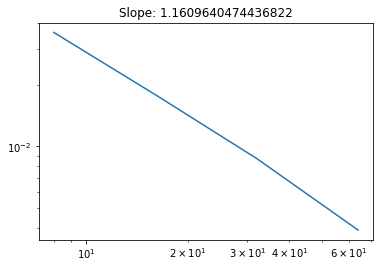

In [5]:
ms = grid_convergence(N=[8,16,32,64,128], plotting=True)

In [6]:
ms


(array([0.03601385, 0.01790069, 0.00873464, 0.00390625]), 1.1609640474436822)

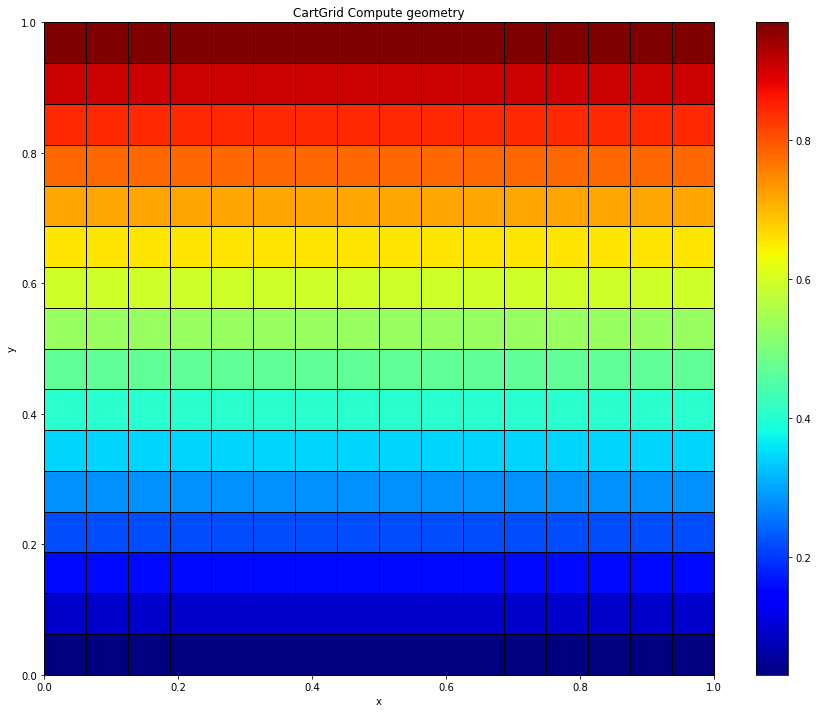

In [7]:
# For reference, a plot of the solution:
Nx = Ny = 16
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()
p = sp_flow(g)
pp.plot_grid(g, p, figsize=(15,12), plot_2d=True)

In [8]:
save = pp.Exporter(g, "solution", folder="results")
save.write_vtk({"pressure": p})

/home/haakon/anaconda3/lib/python3.7/site-packages/vtk/util/numpy_support.py:137: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \
